# Chapter 2 - Random Graph Models

In the first part of this notebook, we provide the code required to generate the Figures in Chapter 2 of the textbook.

In the second part, we consider the GitHub machine learning (ml) developers graph that we introduced in Chapter 1, and compare various statistics for this graph with the values we get for the random graphs models introduced in Chapter 2.

### Requirements

We use one new package in this notebook called ```powerlaw``` which can be installed via ```pip install powerlaw```.
Details and examples of use can be found here: https://arxiv.org/pdf/1305.0215.pdf or here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777.

As with the previous notebook, make sure to set the data directory properly in the next cell.


In [1]:
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import powerlaw
from scipy.stats import poisson
from scipy.optimize import fsolve
import random


# Part 1 - Figures for Chapter 2

## Figure 2.1: size of the giant component

We generate several binomial random graphs with $n$ nodes, where we vary the average node degree (thus, the number of edges). We consider $n=100$ below, and you can try for different $n$. Un-comment the second line to run with $n=10,000$ nodes as in the second plot in the book (this will be much slower).

We plot the theoretical giant component size (black line) and the 90% confidence interval from the empirical data in grey, both as a function of the average degree; we see good agreement and we observe the various phases as described in the book. 

In [3]:
n = 100
# n = 10000 

random.seed(123)

gc_avg = []
gc_std = []

## range of values for average degree and number of repeats for each
avg_deg = np.arange(.1,10.1,.1)
Repeats = 1000

## generate random graphs and gather size of giant component
for deg in avg_deg:
    x = []
    p = deg/(n-1)
    for rep in range(Repeats):
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(g.connected_components().giant().vcount())
    ## average and standard deviation for a given average degree
    gc_avg.append(np.mean(x)) 
    gc_std.append(np.std(x))

## theoretical values
th_val = [np.log(n) for i in np.arange(.1,1.1,.1)] ## small values
def fn(x,d):
    return x+np.exp(-x*d)-1
for i in np.arange(1.1,10.1,.1):
    th_val.append(n*fsolve(fn,1,args=(i))[0])


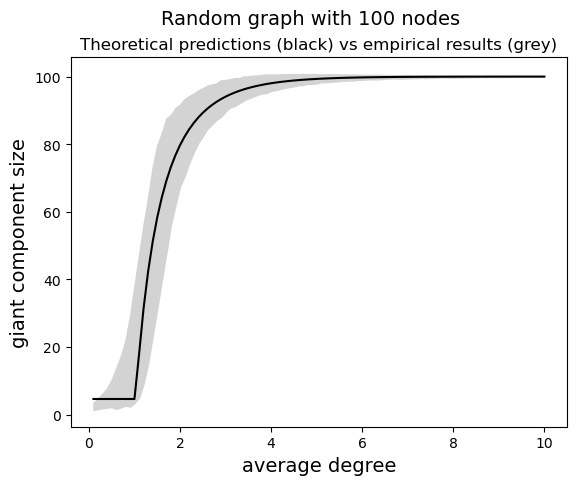

In [4]:
## plot empirical results (confidence intervals) and theoretical values
plt.fill_between(avg_deg,[x[0]-1.654*x[1] for x in zip(gc_avg,gc_std)],
                 [x[0]+1.645*x[1] for x in zip(gc_avg,gc_std)],color='lightgray')
plt.plot(avg_deg,th_val, color='black')
plt.suptitle('Random graph with '+str(n)+' nodes',fontsize=14)
plt.title('Theoretical predictions (black) vs empirical results (grey)',fontsize=12)
plt.xlabel('average degree',fontsize=14)
plt.ylabel('giant component size',fontsize=14);
#plt.savefig('giant_100.eps');

## Figure 2.2: probability that the graph is connected

This is a similar experiment as above, but this time we look at the probability that the random graph is connected.
We vary some constant $c$ introduced in the book such that the edge probability for the binomial graphs is given by $(\log(n)+c)/n$. Once again we compare theory (black line) and experimental results (in grey) with $n=100$ nodes. Un-comment the second line to run with $n=10,000$ nodes as in the second plot in the book (this will be much slower).

In the cell below, the grey area corresponds to a 90% confidence interval for proportions; for empirical proportion $x$ obtained from sample of size $n$, the formula is given by $x \pm 1.645 \sqrt{x(1-x)/n}$.

Here also we see good agreement between theory and experimental results.

In [5]:
n = 100
# n = 10000

random.seed(123)
Repeats = 1000 ## number of repeats for each 'c' value

## set lower bound for the range of values for ‘c’ (to avoid p being negative)
lo = -int(np.floor(np.log(n)*10))/10
if lo < -10:
    lo = -10
c_range = np.arange(lo, 10.1, .1)
ic_avg=[]

## loop over 'c' values
for c in c_range:
    x = []
    p = (c+np.log(n))/n
    for rep in range(Repeats):        
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(int(g.is_connected()))
    ic_avg.append(np.mean(x))

## theoretical values
th = [np.exp(-np.exp(-c)) for c in c_range]


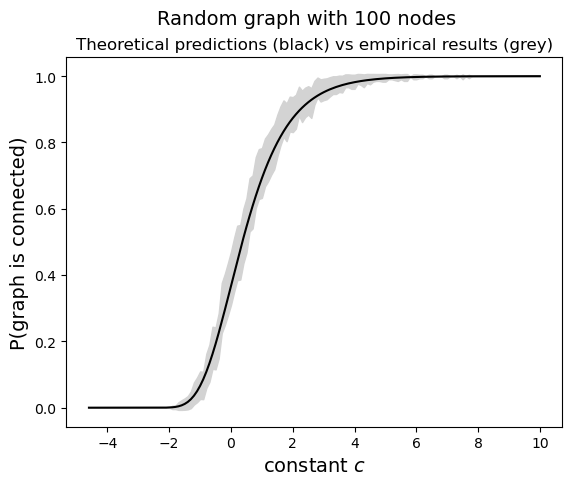

In [6]:
## plot
plt.fill_between(c_range,[x-1.654*np.sqrt(x*(1-x)/n) for x in ic_avg],
                 [x+1.645*np.sqrt(x*(1-x)/n) for x in ic_avg],color='lightgray')
plt.plot(c_range,th,color='black')
plt.suptitle('Random graph with '+str(n)+' nodes',fontsize=14)
plt.title('Theoretical predictions (black) vs empirical results (grey)',fontsize=12)
plt.xlabel(r'constant $c$',fontsize=14)
plt.ylabel('P(graph is connected)',fontsize=14);
#plt.savefig('connected_100.eps');

## Figure 2.4: Distribution of shortest path lengths

We consider a series of binomial random graphs with expected average degree 5, where we vary the number of nodes from $n=64$ to $n=2,048$.

We see that as we double the number of nodes, the average shortest path lengths (in the giant component) increases slowly.


In [7]:
sp_len = []
## number of nodes
n_range = [64,128,256,512,1024,2048]
random.seed(123)

for n in n_range:
    p = 5/(n-1)
    ## keep giant component
    g = ig.Graph.Erdos_Renyi(n=n, p=p).connected_components().giant()
    z = g.distances()
    sp_len.append([x for y in z for x in y if x>0])
    

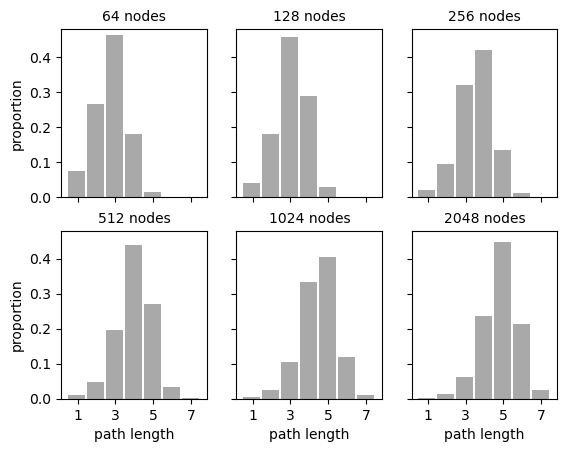

In [8]:
bins = np.arange(0.5,8.5,1)
fig, axs = plt.subplots(2, 3)
#fig.suptitle('Shortest path length distribution')
for i in range(2):
    for j in range(3):
        axs[i,j].hist(sp_len[3*i+j], bins=bins, width=.9, density=True, color='darkgrey')
        axs[i,j].set_ylim(0,.48)
        axs[i,j].set_xticks([1,3,5,7])
        axs[i,j].set_title(str(n_range[3*i+j])+' nodes', fontsize=10)
        axs[i,j].set_xlabel('path length')
        axs[i,j].set_ylabel('proportion')
for ax in fig.get_axes():
    ax.label_outer()
# fig.savefig('path_len.eps');

## Figure 2.5 Poisson vs degree distributions

We plot the degree distribution for binomial random graphs with expected average degree 10, and $n=100$ nodes (the black dots), and we compare with the corresponding Poisson distribution (dashed line).

Try increasing $n$; the dots should get closer to the Poisson distribution.

Un-comment line 2 to run with $n=10,000$ as in the book.


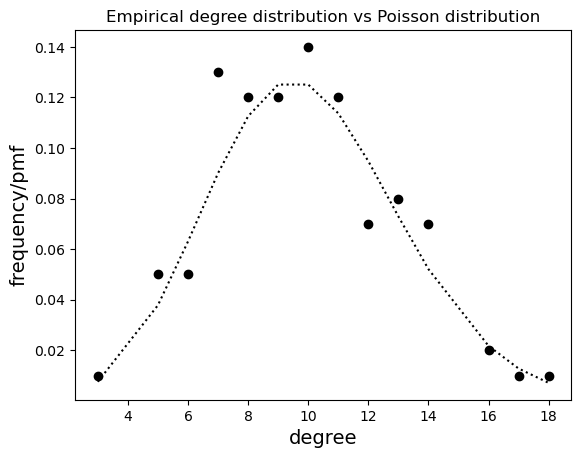

In [9]:
n = 100
# n = 10000 

random.seed(12345)
p = 10/(n-1)
g = ig.Graph.Erdos_Renyi(n=n, p=p)
x = [x[0] for x in sorted(Counter(g.degree()).items())]
pmf = [poisson.pmf(k,10) for k in x]
frq = [x[1]/n for x in sorted(Counter(g.degree()).items())]
plt.plot(x,frq,'o',color='black')
plt.plot(x,pmf,':',color='black')
plt.title('Empirical degree distribution vs Poisson distribution')
plt.xlabel('degree',fontsize=14)
plt.ylabel('frequency/pmf',fontsize=14);
# plt.savefig('poisson_10000.eps');


## Figure 2.6 --  Power law graphs

We generate a random graph with $n=10,000$ nodes following power law degree distribution with exponent $\gamma=2.5$.
We do so using the Chung-Lu models described in section 2.5 of the book; we generate simple graphs (no loops or multiedges) and discard 0-degree nodes.

We then fit and plot the degree distribution of the obtained graph using the ```powerlaw``` package, see: https://arxiv.org/pdf/1305.0215.pdf



In [10]:
## fast Chung-Lu: generate m distinct edges w.r.t. distribution d, no loops
def fast_CL(d, m, seed=123):
    np.random.seed(seed)
    n = len(d)    ## number of nodes
    s = np.sum(d) 
    p = [i/s for i in d] ## we draw nodes w.r.t. degrees
    target = m ## number to generate
    tples = [] ## list of generated edges
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples) ## number left to generate
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples


### generate graph and fit power law model

A few remarks regarding the ```powerlaw``` package:

* ```xmin``` corresponds to $\ell'$ in the book
* ```alpha``` corresponds to $\gamma$ in the book


In [11]:
## power law graph
#np.random.seed(23) 
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees (details in the book)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))
#deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fast_CL(deg, m, seed=23)
g_pl = ig.Graph.TupleList(tpl)

## number of isolated nodes (no edges)
iso = n-g_pl.vcount()
print('number of isolated nodes:',iso,'\n')

## run powerlaw and compute Kolmogorov-Smirnov statistic (details in the book)
deg = g_pl.degree()
X = powerlaw.Fit(deg)
print('\n\nRange of degrees in graph:',min(deg),max(deg))
print("Value of l':",X.power_law.xmin)
print("Corresponding value of gamma:",X.power_law.alpha)


number of isolated nodes: 1921 

Calculating best minimal value for power law fit
xmin progress: 98%

Range of degrees in graph: 1 113
Value of l': 7.0
Corresponding value of gamma: 2.8894081201459163


### Divergence vs $\ell$

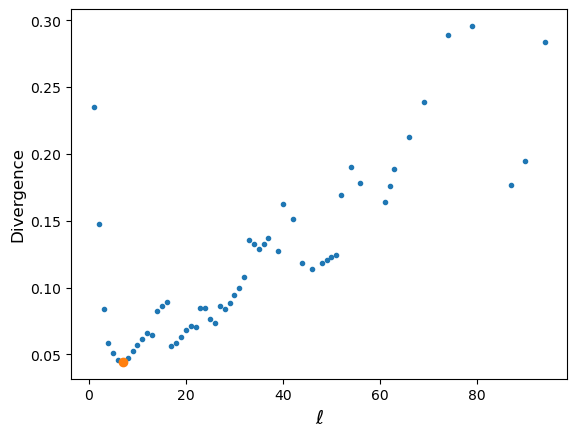

In [12]:
## Plot divergence vs 'l'
x = X.xmins
y = X.Ds
plt.plot(x, y, '.')

## Plot min value with larger dot
x = int(X.power_law.xmin)
y = X.Ds[x-1]
plt.plot([x],[y],'o')
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel('Divergence', fontsize=12);

### Figure 2.6 - inverse (cumulative) cdf vs degree and fitter power law

In the first plot, we look at degrees starting from $\ell'$.

In the second plot, we look at the whole range of degree.

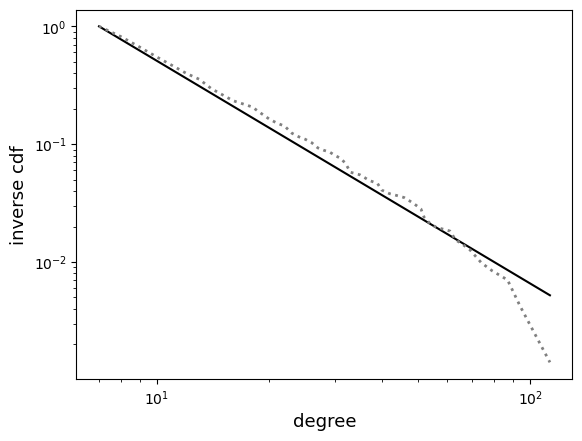

In [13]:
## Figure 2.6 - starting from l' 
fig1 = X.power_law.plot_ccdf(color='black', linestyle='-');
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color='gray', original_data=False, linestyle=':')
fig1.set_xlabel('degree', fontsize=13)
fig1.set_ylabel('inverse cdf', fontsize=13);


power law slope: -1.889408120145914


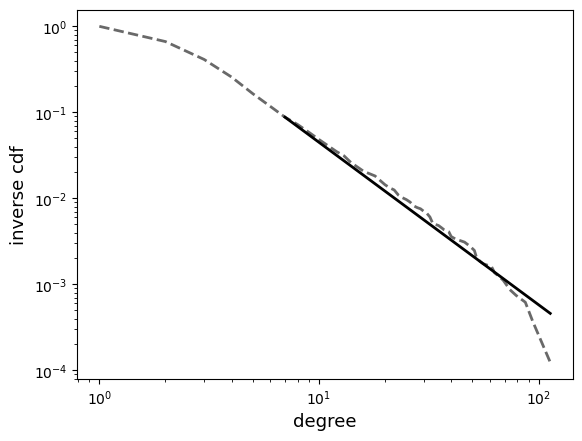

In [14]:
## now starting from 1 - need to translate power law line manually
fig = X.plot_ccdf(linewidth=2, color='dimgray', original_data=True, linestyle='--')
fig.set_xlabel('degree', fontsize=13)
fig.set_ylabel('inverse cdf', fontsize=13)

## get end points for power law fitted line
x = [int(X.power_law.xmin), int(X.data[-1:][0])]     ## x-axis: from l' to max value in data
delta_y = X.ccdf(original_data=True)[1][x[0]-1]   ## translation for first point
y = [delta_y, X.power_law.ccdf()[-1:][0]*delta_y] ## y-axis values
plt.plot(x,y,'-',linewidth=2, color='black')
print('power law slope:',(np.log10(y[1])-np.log10(y[0]))/(np.log10(x[1])-np.log10(x[0])));

# plt.savefig('powerlaw.eps');

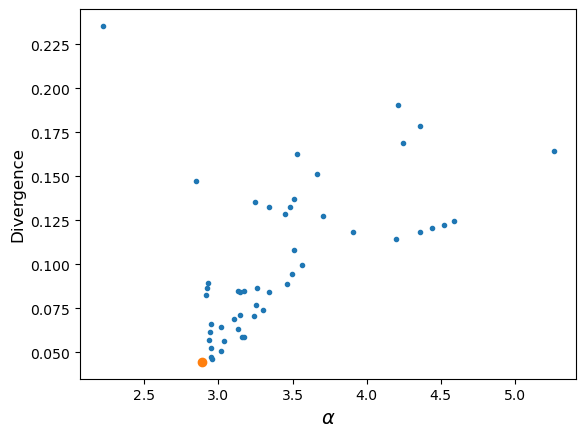

In [15]:
## plot divergence vs. exponent (alpha here, gamma' in the book)
plt.plot(X.alphas[:50],X.Ds[:50],'.')

## Plot min value with larger dot
i = int(X.power_law.xmin)
x = X.alphas[i-1]
y = X.Ds[i-1]
plt.plot([x],[y],'o')
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('Divergence', fontsize=12);


## Figure 2.7: simple $d$-regular graphs

We generate several $d$-regular graphs and count how many are simple graphs.
We consider $d=2$ to $d=10$, with $n=100$ nodes. Un-comment the second line to run with $n=10,000$ nodes as in the book.

We plot the empirical proportion of simple graphs below (black dots), and we compare with the theoretical values (dashed line). We see good agreement even for small value $n=100$.


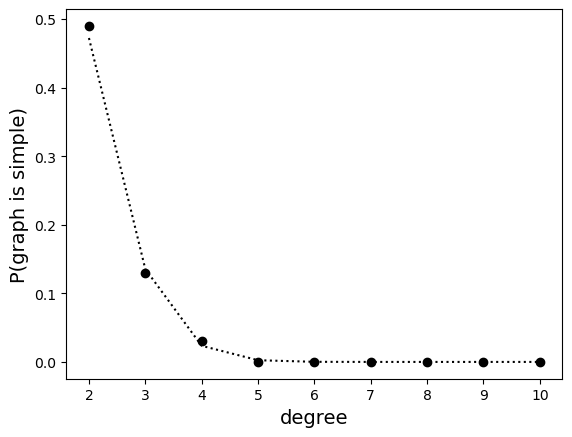

In [16]:
n = 100
# n = 10000

random.seed(1234)
Repeats = 100
Degs = np.arange(2,11) 
simple = []

## count number of simple graphs
for deg in Degs:
    x = 0
    for rep in range(Repeats):
        g = ig.Graph.Degree_Sequence([deg for i in range(n)])
        x += int(g.is_simple())
    simple.append(x/Repeats)
th_simple = [np.exp(-(deg*deg-1)/4) for deg in Degs]

## plot empirical and theoretical results
plt.plot(Degs, simple, 'o', color='black')
plt.plot(Degs, th_simple, ':', color='black')
plt.xlabel('degree', fontsize=14)
plt.ylabel('P(graph is simple)', fontsize=14);

# plt.savefig('d-reg_100.eps');

## Section 2.8 - Random geometric graphs (RGG)

With this model, $n$ nodes are dropped randomly on the d-dimensional space $[0,1]^d$.
Two nodes are connected by an edge if their distance is less than some **radius** parameter $r$.
We consider the **unit square**, so we fix $d=2$ in our examples.

For RGG on the unit square, the (expected) average degree of a node in a graph with $n$ nodes is $\pi r^2 (n-1)$ where $r$ is the radius parameter, unless the node is near the square boundary. Near the boundary, this approximation is actually slightly larger than the true expected average degree due to boundary effects (nodes close to the boundary of the square will have a smaller number of connections).

We can slightly modify this model by considering a unit **torus**. This will eliminate boundary effects so all nodes have (expected) average degree $\pi r^2 (n-1).$ 

In all experiments below, you can use either the unit square by setting ```torus=False```, or the torus model by setting ```torus=True```.


### Looking at some RGGs

We plot some geometric random graphs with $n=100$ nodes and varying radius threshold $r$.

Note that the ```igraph``` function to generate such graphs is called ```Graph.GRG```. When generating such a graph, the position of the nodes in the square or torus are saved as **vertex attributes** 'x' and 'y'.



Geometric random graph with radius = 0.15


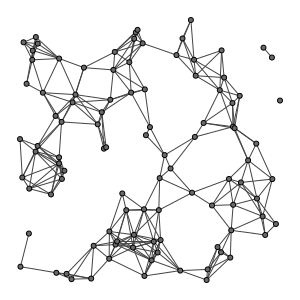

In [17]:
## plotting a few random geometric graphs with 100 nodes and varying radius threshold
n = 100
torus = False ## Set to True to see a torus-based RGG, else we use the unit square

## select a value for the radius:
#radius = 0.1
radius = 0.15
#radius = 0.2

random.seed(1234)
g = ig.Graph.GRG(n=n, radius=radius, torus=torus)
print('\nGeometric random graph with radius =',radius) 
ly = [(x,y) for x,y in zip(g.vs['x'],g.vs['y'])] ## position of the nodes are saved as attributes
ig.plot(g, layout=ly, bbox=(300,300), vertex_size=5, vertex_color='dimgrey')

# to save the plot:
# fn = 'grg_'+str(int(100*radius))+'.eps'
# ig.plot(g, fn, bbox=(300,300), vertex_size=5, vertex_color='dimgrey')


### RGG - size of the giant component

Next we look at the size of the giant component for geometric random graphs on the unit square as we vary the radius parameter.

For RGG on the unit square, the (expected) average degree of a node in a graph with $n$ nodes is $\pi r^2 (n-1)$ where $r$ is the radius parameter, unless the node is near the square boundary. Near the boundary, this approximation is actually slightly larger than the true expected average degree due to boundary effects (nodes close to the boundary of the square will have a smaller number of connections).

In the experiment below, we fix some degree range and compute the corresponding radius parameters $r$.
For each value $r$, we generate 1,000 GRGs and compute the mean and standard deviation for the size of the 
giant component.

We see a similary shape as with binomial (Erdos-Renyi) random graphs.

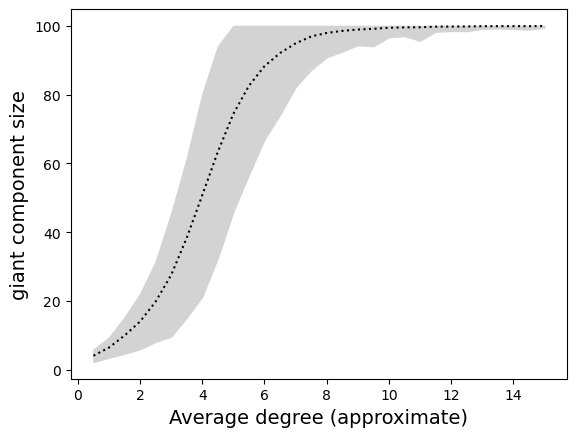

In [18]:
## experiment - size of the giant component vs radius threshold

## Set to True to see a torus-based RGG, else we use the unit square
torus = False 
## number of nodes:
n = 100
#n = 10000 ## this takes a few minutes

repeats = 1000
random.seed(1234)
average_degree = np.arange(.5,15.1,.5)

## range of values for the radius parameter
radii = [np.sqrt(i/(np.pi*(n-1))) for i in average_degree]

gc_avg = [] ## store average giant component sizes
gc_std = [] ## ... and the standard deviations
deg_avg = [] ## we also store the true mean empirical average degrees

## generate random graphs and gather the sizes of the giant component
for radius in radii:
    x = []
    y = []
    for rep in range(repeats):
        g = ig.Graph.GRG(n=n, radius=radius, torus=torus)
        x.append(g.connected_components().giant().vcount())
        y.append(np.mean(g.degree()))
    ## average and standard deviation for a given radius
    gc_avg.append(np.mean(x)) 
    gc_std.append(np.std(x))
    deg_avg.append(np.mean(y))
    
## plot the above empirical results (confidence intervals and mean values)
plt.fill_between(average_degree,[x[0]-1.654*x[1] for x in zip(gc_avg,gc_std)],
                 [min(n,x[0]+1.645*x[1]) for x in zip(gc_avg,gc_std)],color='lightgray')
plt.plot(average_degree, gc_avg, color='black', linestyle=':')
#plt.suptitle('Geometric random graphs with '+str(n)+' nodes',fontsize=14)
#plt.title('Empirical results',fontsize=12)
plt.xlabel('Average degree (approximate)',fontsize=14)
plt.ylabel('giant component size',fontsize=14);

## to save the plot:
#fn = 'grg_giant_'+str(n)+'.eps'
#plt.savefig(fn);

### degreee formula vs empirical results

For the experiment above, we compare the empirical average degrees with the formula presented earlier.
If the experiment was conducted on the unit square (with ```torus=False```), then the empirical degrees are slightly smaller than the ones computes with the formula -- this is clearly seen by comparing with a unit slope line. However if the experiment was conducted on torus (with ```torus=True```), then the values are the same.

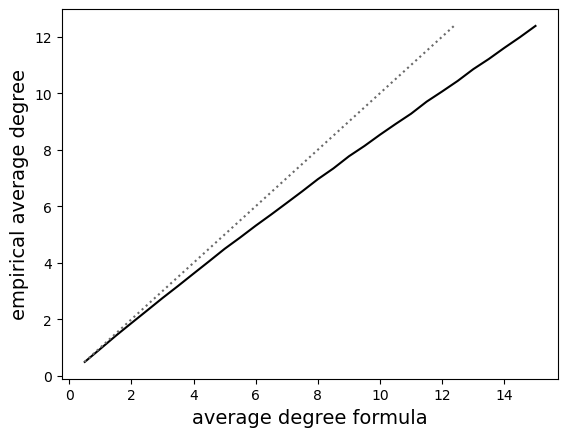

In [19]:
## compare the empirical average degrees for the previous experiment with the approximation formula
## we also plot a line with slope = 1 for easier comparison
plt.plot(average_degree,deg_avg, color='black')
plt.plot(deg_avg, deg_avg,':',color='dimgray')
plt.ylabel('empirical average degree',fontsize=14)
plt.xlabel('average degree formula',fontsize=14);

## Connectivity of RGGs

This time we look at the probability that the random graph is connected.
We vary some constant $c$ introduced in the book such that the radius $r$ for the RGGs is given by $n\pi r^2 = \ln n + c$. We compare theory (black line) and experimental results (in grey) with $n=100$ nodes. 
Un-comment the second line to run with $n=10,000$ nodes as in the second plot in the book (this will be much slower).

In the cell below, the grey area corresponds to a 90% confidence interval for proportions; for empirical proportion $x$ obtained from sample of size $n$, the formula is given by $x \pm 1.645 \sqrt{x(1-x)/n}$.

In this case, if we generate RGGs on a square, boundary nodes will have a higher chance of being isolated, so the convergence to the theoretical result with resdpect to $n$ is slow, as we observe in the results below.
Working on a torus, we see faster convergence, but even with $n = 10,000$, there is still some small differences.


In [20]:
## Pr(graph is connected)

torus = False
n = 100
# n = 10000 ## this will take several minutes

random.seed(123)
Repeats = 1000 ## number of repeats for each 'c' value

## set lower bound for the range of values for 'c'
lo = -int(np.floor(np.log(n)*10))/10
if lo < -5:
    lo = -5
c_range = np.arange(lo, 10.1, .1)
ic_avg=[]

## loop over 'c' values
for c in c_range:
    x = []
    r = np.sqrt( (c+np.log(n)) / (np.pi*(n)) )
    for rep in range(Repeats):        
        g = ig.Graph.GRG(n=n, radius=r, torus=torus)
        x.append(int(g.is_connected()))
    ic_avg.append(np.mean(x))

## theoretical values
th = [np.exp(-np.exp(-c)) for c in c_range]


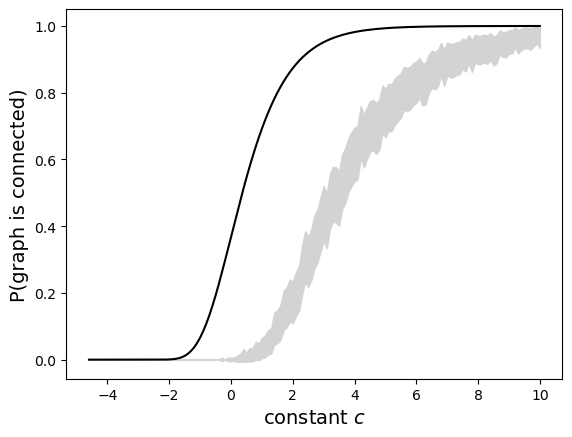

In [21]:
## plot
plt.fill_between(c_range,[x-1.654*np.sqrt(x*(1-x)/n) for x in ic_avg],
                 [x+1.645*np.sqrt(x*(1-x)/n) for x in ic_avg],color='lightgrey')
#plt.plot(c_range, ic_avg, '-', color='black')
plt.plot(c_range, th, '-', color='black')
#plt.suptitle('Geometric random graph with '+str(n)+' nodes',fontsize=14)
#plt.title('Theoretical predictions (black) vs empirical results (grey)',fontsize=12)
plt.xlabel(r'constant $c$',fontsize=14)
plt.ylabel('P(graph is connected)',fontsize=14);

## to save the plot:
# if torus:
#     fn = 'grg_connected_torus_'+str(n)+'.eps'
# else:
#     fn = 'grg_connected_square_'+str(n)+'.eps'
# plt.savefig(fn);


# Part 2 -- Experiments with random graphs

We use the giant component of the **GitHub machine learning (ml) developers** subgraph that we introduced in Chapter 1. Recall this graph has 7,083 nodes and 19,491 edges. 

We compute several graphs statistics for this "base graph", as reported in the first column of **Table 2.8** from the book.

We then generate **random** graphs with the same number of nodes and edges using 4 different models:
* binomial or Erdos-Renyi: only average degree is used
* Chung-Lu: expected degree distribution
* Configuration: exact degree distribution
* Configuration with Viger method: connected, simple graph is obtained

See **section 2.8** of the book for a more complete discussion of the results, but as a general observation, more complex models (such as the configuration model with Viger method) tend to preserve more characteristics of the reference graph.


In [22]:
## read the GitHub edge list as tuples and build undirected graph (as in Chapter 1)
df = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
GitHubGraph = ig.Graph.TupleList([tuple(x) for x in df.values], directed = False, vertex_name_attr='id')

## read node attributes
Attr = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')
## build attribute dictionaries
Names = dict(zip(Attr.id,Attr.name))
ML = dict(zip(Attr.id,Attr.ml_target))
## add name attributes to graph
GitHubGraph.vs['name'] = [Names[i] for i in GitHubGraph.vs['id']]
## add a class: 'ml' or 'web' depending on attribute 'ml_label'
labels = ['web','ml']
GitHubGraph.vs['class'] = [labels[ML[i]] for i in GitHubGraph.vs['id']]

## for github, 9739 are ml developers, build the subgraph and keep the giant component
subgraph_ml = GitHubGraph.subgraph([v for v in GitHubGraph.vs() if v['class']=='ml'])
subgraph_ml = subgraph_ml.connected_components().giant()
print(subgraph_ml.vcount(),'nodes and',subgraph_ml.ecount(),'edges')

7083 nodes and 19491 edges


In [23]:
## return statistics in Table 2.8 
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.max(deg),G.diameter(),
     np.max(G.connected_components().membership)+1,G.connected_components().giant().vcount(),sum([x==0 for x in G.degree()]),
     G.transitivity_undirected(),G.transitivity_avglocal_undirected()]
  

In [24]:
random.seed(123)

## Compute and store statistics for Base (subgraph_ml) graphs
S = []
S.append(['Base Graph'] + baseStats(subgraph_ml))

## Append statistics for Erdos-Renyi graph with same number of nodes and edges
g_er = ig.Graph.Erdos_Renyi(n=subgraph_ml.vcount(), m=subgraph_ml.ecount())
S.append(['Erdos-Renyi'] + baseStats(g_er))

## Append statistics for Chung-Lu graph with same (expected) degree distribution
tuples = fast_CL(subgraph_ml.degree(),subgraph_ml.ecount(), seed=123) 
g_cl = ig.Graph.Erdos_Renyi(n=subgraph_ml.vcount(), m=0)
g_cl.add_edges(tuples)
S.append(['Chung-Lu'] + baseStats(g_cl))

## Append statistics for configuration model graph with same degree distribution
g_cm = ig.Graph.Degree_Sequence(subgraph_ml.degree(), method='simple')
S.append(['Configuration'] + baseStats(g_cm))

## Append statistics for configuration model simple graph with same degree distribution
g_cmv = ig.Graph.Degree_Sequence(subgraph_ml.degree(), method='vl')
S.append(['Configuration (V)'] + baseStats(g_cmv))

## Store in dataframe and show results
df = pd.DataFrame(S,columns=['graph','nodes','edges',r'$\delta = d_{min}$',r'$d_{mean}$',
                             r'$d_{median}$',r'$\Delta = d_{max}$','diameter','components','largest','isolates',
                             r'$C_{glob}$',r'$C_{loc}$']).transpose()
df


,0,1,2,3,4
graph,Base Graph,Erdos-Renyi,Chung-Lu,Configuration,Configuration (V)
nodes,7083,7083,7083,7083,7083
edges,19491,19491,19491,19491,19491
$\delta = d_{min}$,1,0,0,1,1
$d_{mean}$,5.5036,5.5036,5.5036,5.5036,5.5036
$d_{median}$,2.0,5.0,3.0,2.0,2.0
$\Delta = d_{max}$,482,17,426,482,482
diameter,13,10,9,10,11
components,1,29,1074,68,1
largest,7083,7054,5990,6942,7083


### shortest path length distribution

We compute and compare the shortest path length distribution for several node pairs and for the 5 graphs we have (GitHub ml reference graph, and 4 random graphs). Sampling is used to speed-up the process.

We consider the giant component for disconnected graphs.

We see a reasonably high similarity for all graphs, with the binomial random graph having slightly longer path lengths due to the absence of high degree (hub) nodes in that model.


In [25]:
## sampling -- doing all vertices is slow
sample_size = 1000
np.random.seed(123) 

## using the giant component for disconnected graphs
g_er_gcc = g_er.connected_components().giant()
g_cl_gcc = g_cl.connected_components().giant()
g_cm_gcc = g_cm.connected_components().giant()

## compute shortest paths (exclude 0-length, i.e. distance to self)
## n.b.: we sample separately since we use the giant components and graphs may
##       have a different number of nodes (except the first and last one)
sp_sg = []
for v in np.random.choice(subgraph_ml.vcount(),size=sample_size,replace=False):
    sp_sg.extend([i for i in subgraph_ml.distances(source=v)[0] if i>0])
sp_er = []
for v in np.random.choice(g_er_gcc.vcount(),size=sample_size,replace=False):
    sp_er.extend([i for i in g_er_gcc.distances(source=v)[0] if i>0])
sp_cl = []
for v in np.random.choice(g_cl_gcc.vcount(),size=sample_size,replace=False):
    sp_cl.extend([i for i in g_cl_gcc.distances(source=v)[0] if i>0])
sp_cm = []
for v in np.random.choice(g_cm_gcc.vcount(),size=sample_size,replace=False):
    sp_cm.extend([i for i in g_cm_gcc.distances(source=v)[0] if i>0])
sp_cmv = []
for v in np.random.choice(g_cmv.vcount(),size=sample_size,replace=False):
    sp_cmv.extend([i for i in g_cmv.distances(source=v)[0] if i>0])


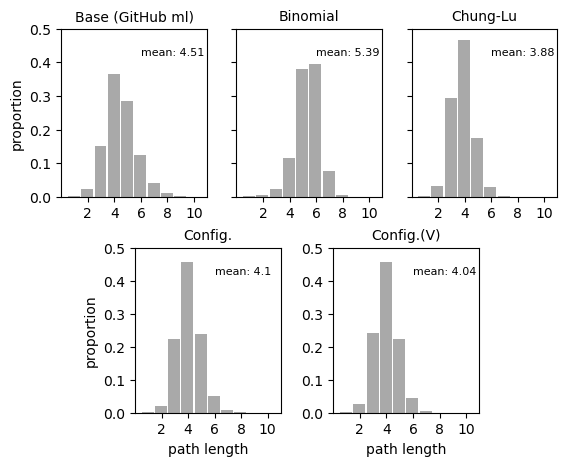

In [26]:
## compare shortest path length distributions
bins = np.arange(0.5,11.5,1)
fig, axs = plt.subplots(2, 3)
#fig.suptitle('Shortest path length distribution')

## plot the 5 histograms
axs[0,0].hist(sp_sg, bins=bins, width=.9, density=True, color='darkgrey')
axs[0,0].set_title('Base (GitHub ml)',fontsize=10)
axs[0,1].hist(sp_er, bins=bins, width=.9, density=True, color='darkgrey')
axs[0,1].set_title('Binomial',fontsize=10)
axs[0,2].hist(sp_cl, bins=bins, width=.9, density=True, color='darkgrey')
axs[0,2].set_title('Chung-Lu',fontsize=10)
axs[1,0].hist(sp_cm, bins=bins, width=.9, density=True, color='darkgrey')
axs[1,0].set_title('Config.',fontsize=10)
axs[1,1].hist(sp_cmv, bins=bins, width=.9, density=True, color='darkgrey')
axs[1,1].set_title('Config.(V)',fontsize=10)

## set uniform y-range and ticks
for i in range(2):
    for j in range(3):
        axs[i,j].set_ylim(0,.5)
        axs[i,j].set_xticks([2,4,6,8,10])

## adjust 3-2 format
axs[1,2].set_visible(False)
axs[1,0].set_position([0.24,0.08,0.228,0.343])
axs[1,1].set_position([0.55,0.08,0.228,0.343])

## labels only on the outer axis
axs[0,0].set_ylabel('proportion')  
axs[1,0].set_ylabel('proportion')  
axs[1,0].set_xlabel('path length')  
axs[1,1].set_xlabel('path length')  
axs[0,1].get_yaxis().set_ticklabels([])
axs[0,2].get_yaxis().set_ticklabels([]);

## add mean values
axs[0,0].text(6,.42,'mean: '+str(float('%.3g' % np.mean(sp_sg))),fontsize=8)
axs[0,1].text(6,.42,'mean: '+str(float('%.3g' % np.mean(sp_er))),fontsize=8)
axs[0,2].text(6,.42,'mean: '+str(float('%.3g' % np.mean(sp_cl))),fontsize=8)
axs[1,0].text(6,.42,'mean: '+str(float('%.3g' % np.mean(sp_cm))),fontsize=8)
axs[1,1].text(6,.42,'mean: '+str(float('%.3g' % np.mean(sp_cmv))),fontsize=8);

#fig.savefig('pathlens_random.eps',bbox_inches='tight')


# Extra material

## More power law tests - GitHub subgraphs and Grid graph

We try to fit power law for the degree distributions as we did before, this time for 3 real graphs:
* GitHub ml developers (giant component)
* GitHub web developers (giant component)
* Grid (Europe power grid graph, giant component)

While the first two exhibit power law degree distribution, this is not the case for the Grid graph.


### GitHub ml subgraph

In [27]:
## build the subgraphs
subgraph_ml = GitHubGraph.subgraph([v for v in GitHubGraph.vs() if v['class']=='ml'])
subgraph_ml =subgraph_ml.connected_components().giant()

## estimates for l' (xmin) and gamma (alpha)
deg = subgraph_ml.degree()
X = powerlaw.Fit(deg)
print('\ngamma:',X.power_law.alpha)
print('l\':',X.power_law.xmin)
print('KS statistic:',X.power_law.D)


Calculating best minimal value for power law fit
xmin progress: 98%
gamma: 2.738668071696395
l': 16.0
KS statistic: 0.022582027049761866


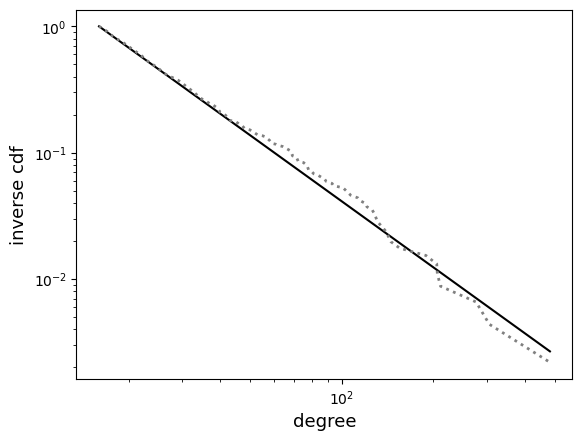

In [28]:
## Starting from l' 
fig1 = X.power_law.plot_ccdf(color='black', linestyle='-');
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color='gray', original_data=False, linestyle=':')
fig1.set_xlabel('degree', fontsize=13)
fig1.set_ylabel('inverse cdf', fontsize=13);


### GitHub web subgraph

In [29]:
subgraph_web = GitHubGraph.subgraph([v for v in GitHubGraph.vs() if v['class']=='web'])
subgraph_web =subgraph_web.connected_components().giant()

## estimates for l' (xmin) and gamma (alpha)
deg = subgraph_web.degree()
X = powerlaw.Fit(deg)
print('\ngamma:',X.power_law.alpha)
print('l\':',X.power_law.xmin)
print('KS statistic:',X.power_law.D)


Calculating best minimal value for power law fit
xmin progress: 99%
gamma: 2.53890197931916
l': 50.0
KS statistic: 0.011297367521548307


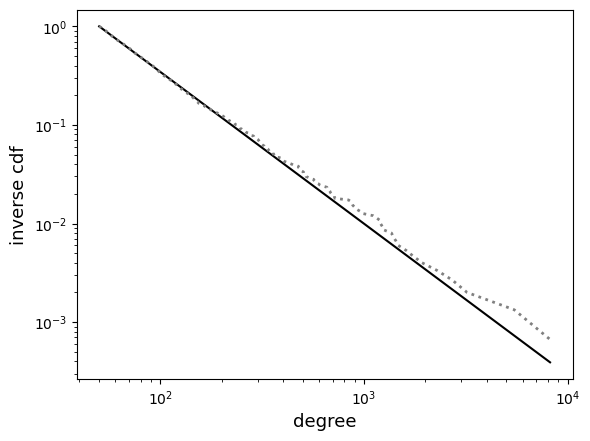

In [30]:
## Starting from l' 
fig1 = X.power_law.plot_ccdf(color='black', linestyle='-');
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color='gray', original_data=False, linestyle=':')
fig1.set_xlabel('degree', fontsize=13)
fig1.set_ylabel('inverse cdf', fontsize=13);


### Grid graph

In [31]:
Grid = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
Grid = Grid.simplify()
## keep the giant component
Grid = Grid.connected_components().giant()

## estimates for l' (xmin) and gamma (alpha)
deg = Grid.degree()
X = powerlaw.Fit(deg)
print('\ngamma:',X.power_law.alpha)
print('l\':',X.power_law.xmin)
print('KS statistic:',X.power_law.D)


Calculating best minimal value for power law fit
xmin progress: 92%
gamma: 5.860107700269038
l': 4.0
KS statistic: 0.1367051903592863


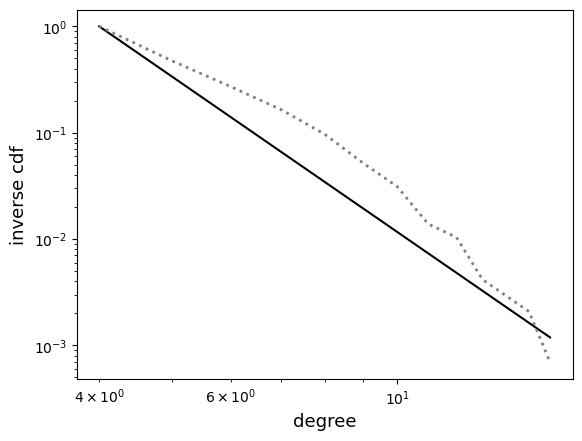

In [32]:
## Starting from l' 
fig1 = X.power_law.plot_ccdf(color='black', linestyle='-');
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color='gray', original_data=False, linestyle=':')
fig1.set_xlabel('degree', fontsize=13)
fig1.set_ylabel('inverse cdf', fontsize=13);


## Independent sets

Illustrating a few functions to find independent sets.

In [33]:
## generate random graph with (at least one) independent set 
## n: nodes, s: independent set size, d: avg degree
def indepSet(n, s, d, seed=123):
    random.seed(seed)
    np.random.seed(seed)
    N = n-s
    di = n*d//2-s*d
    ## random graph with N nodes
    g = ig.Graph.Erdos_Renyi(n=N,m=di)
    ## extra nodes
    g.add_vertices(s)
    ## assign remaining degree to extra nodes
    z = np.random.choice(np.arange(N,n),size=s*d)
    deg = [x[1] for x in sorted(Counter(z).items())]
    for i in range(len(deg)):
        e = np.random.choice(N,deg[i],replace=False)
        for j in e:
            g.add_edge(j,i+N)
    p = list(np.random.permutation(n))
    G = g.permute_vertices(p)
    return G


In [34]:
## 50 nodes, set size 10, average degree 20
g = indepSet(50, 10, 20, seed=123)

## every set of size min or more
#ivs = g.independent_vertex_sets(min=9)

## largest set(s) only
ivs = g.largest_independent_vertex_sets()

## maximal sets (that can't be extended)
#ivs = g.maximal_independent_vertex_sets()

print(g.independence_number())

ivs

10


[(0, 2, 5, 18, 27, 35, 37, 39, 43, 44)]